<a href="https://colab.research.google.com/github/scottthomaswx/RadarHodographs/blob/main/RadarHodograph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Needed Packages

In [5]:
# @title
%%capture
!pip install matplotlib
!pip install numpy
!pip install arm-pyart
!pip install metpy
!pip install nexradaws
!pip install pytz
!pip install datetime

import matplotlib.pyplot as plt
from metpy.units import units
import pyart
import numpy as np
from metpy.plots import Hodograph
import nexradaws
import pytz
import metpy.calc as mpcalc
from datetime import datetime

!mkdir radar_data
!mkdir cf_radial

#Get Needed Parameters

In [6]:
timezone = pytz.timezone('UTC') #Note Format for US Timezones is 'US/Eastern', 'US/Central' etc...
radar_id = 'KGRR'
start = timezone.localize(datetime(2023,8,24,23,0))
end = timezone.localize(datetime(2023,8,25,2,0))

#Establish AWS Connection

In [7]:
# @title
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))

There are 32 scans available between 2023-08-24 23:00:00+00:00 and 2023-08-25 02:00:00+00:00



#Download Radar Data

In [8]:
# @title
%%capture
results = conn.download(scans[0:], '/content/radar_data')

#Select file of choice from radar_data folder and copy path below

In [9]:
file = '/content/radar_data/KGRR20230824_235621_V06'

#Get Needed Strings and Get Radar File

In [10]:
# @title
%%capture

rad = file.split('/')[3]
time = rad.split('_')[1]
seg = rad.split('_')[0]
date = seg[4:]

n = 2

out = []
for i in range(0, len(time), n):
    out.append(time[i:i+n])

datearr = []
for i in range(0, len(date), n):
    datearr.append(date[i:i+n])

radar = pyart.io.read(file)
radar

# create a gate filter which specifies gates to exclude from dealiasing
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_invalid("velocity")
gatefilter.exclude_invalid("reflectivity")
gatefilter.exclude_outside("reflectivity", 0, 80)

# perform dealiasing
dealias_data = pyart.correct.dealias_region_based(radar, gatefilter=gatefilter)
radar.add_field("corrected_velocity", dealias_data)

pyart.io.write_cfradial(f'/content/cf_radial/{rad}.nc', radar, format='NETCDF4')

#Create Vertical Wind Profile

In [29]:
# @title
%%capture
ncrad = pyart.io.read_cfradial(f'/content/cf_radial/{rad}.nc')

# Loop on all sweeps and compute VAD
zlevels = np.arange(0, 9000, 100)  # height above radar
u_allsweeps = []
v_allsweeps = []

for idx in range(ncrad.nsweeps):
    radar_1sweep = ncrad.extract_sweeps([idx])
    vad = pyart.retrieve.vad_browning(
        radar_1sweep, "corrected_velocity", z_want=zlevels
    )
    u_allsweeps.append(vad.u_wind)
    v_allsweeps.append(vad.v_wind)

# Average U and V over all sweeps and compute magnitude and angle
u_avg = np.nanmean(np.array(u_allsweeps), axis=0)
v_avg = np.nanmean(np.array(v_allsweeps), axis=0)
orientation = np.rad2deg(np.arctan2(-u_avg, -v_avg)) % 360
speed = np.sqrt(u_avg**2 + v_avg**2)

#Convert to Knots and Calculate SRM

In [30]:
# @title
u_avg *= 1.944
v_avg *= 1.944

sm_dir = 317
sm_speed = 24

u_sm = 24 * np.cos(np.deg2rad(317))
v_sm = 24 * np.sin(np.deg2rad(317))

sr_u = u_avg - u_sm
sr_v = v_avg - v_sm

#Plot Base Hodograph

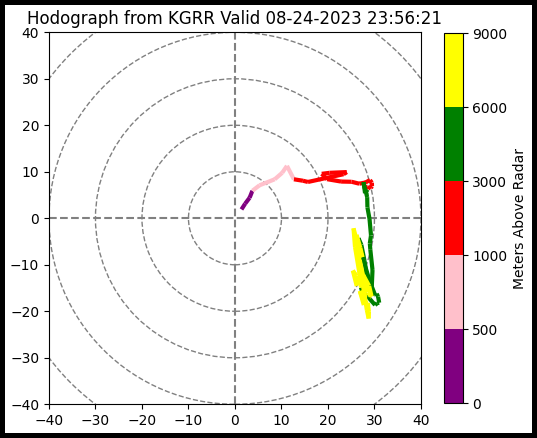

In [31]:
# @title
import matplotlib.colors as colors
fig = plt.figure(figsize=(6,6), facecolor='white', edgecolor="black", linewidth = 6)
ax=fig.add_subplot(1,1,1)
h = Hodograph(ax, component_range = 40)
h.add_grid(increment = 10)
boundaries = np.array([0,500,1000,3000,6000,9000])
colors = ['purple', 'pink', 'red', 'green', 'yellow']
l = h.plot_colormapped(u_avg, v_avg, zlevels + radar.altitude["data"], intervals = boundaries, colors = colors)
CS = plt.colorbar(l, shrink=0.8)
CS.set_label('Meters Above Radar')
plt.title(f'Hodograph from {radar_id} Valid {datearr[2]}-{datearr[3]}-{datearr[0]}{datearr[1]} {out[0]}:{out[1]}:{out[2]}')
plt.savefig(f'Hodograph_{radar_id}_{date}_{time}')

#Storm Relative Hodograph

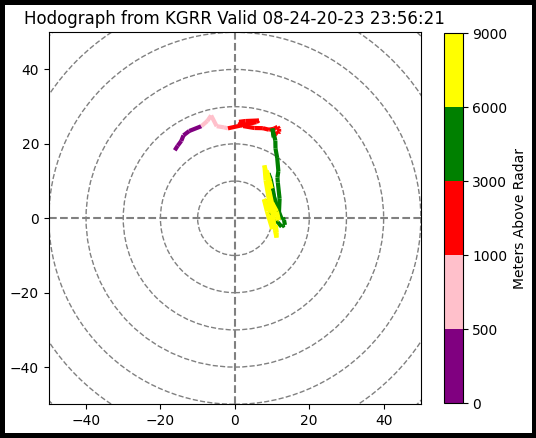

In [33]:
# @title
import matplotlib.colors as colors
fig = plt.figure(figsize=(6,6), facecolor='white', edgecolor="black", linewidth = 6)
ax=fig.add_subplot(1,1,1)
h = Hodograph(ax, component_range = 50)
h.add_grid(increment = 10)
boundaries = np.array([0,500,1000,3000,6000,9000])
colors = ['purple', 'pink', 'red', 'green', 'yellow']
l = h.plot_colormapped(sr_u, sr_v, zlevels, intervals = boundaries, colors = colors)
CS = plt.colorbar(l, shrink=0.8)
CS.set_label('Meters Above Radar')
plt.title(f'Hodograph from {radar_id} Valid {datearr[2]}-{datearr[3]}-{datearr[0]}-{datearr[1]} {out[0]}:{out[1]}:{out[2]}')
plt.savefig(f'StormRelativeHodograph_{radar_id}_{date}_{time}')